In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Reshape, Conv2D, Conv1D
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
import numpy as np
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
NAME = 'for_generator_korean(3_label)'
TRAIN_DATA_DIR = f'../../data/{NAME}/train'
VALIDATION_DATA_DIR = f'../../data/{NAME}/val'
TEST_DATA_DIR = f'../../data/{NAME}/test'
 
TRAIN_SAMPLES = 16284 
VALIDATION_SAMPLES = 2036
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
EPOCH = 30

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
 
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 16284 images belonging to 3 classes.
Found 2034 images belonging to 3 classes.


학습

In [4]:
def model_maker(num_class, input_shape=(224, 224, 3)):
    # model = VGG16(weights='imagenet', include_top=True)
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    print(len(base_model.layers))
 
    # for layer in base_model.layers[:]:
        # layer.trainable = False
    for layer in base_model.layers[:100]:
        print('freeze: ', layer.name , str(layer.trainable))
        layer.trainable = False 
 
    input = tf.keras.Input(shape=input_shape)
    custom_model = base_model(input)
    custom_model = tf.keras.layers.GlobalAveragePooling2D()(custom_model)
    custom_model = tf.keras.layers.Dropout(0.2)(custom_model)
    custom_model = tf.keras.layers.Dense(32, activation='relu')(custom_model)
    predictions = tf.keras.layers.Dense(num_class, activation='softmax')(custom_model)
    
    return tf.keras.Model(inputs=input, outputs=predictions)

model_final = model_maker(3, input_shape=(224, 224, 3))
model_final.summary()
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['acc'])

154
freeze:  input_1 True
freeze:  Conv1 True
freeze:  bn_Conv1 True
freeze:  Conv1_relu True
freeze:  expanded_conv_depthwise True
freeze:  expanded_conv_depthwise_BN True
freeze:  expanded_conv_depthwise_relu True
freeze:  expanded_conv_project True
freeze:  expanded_conv_project_BN True
freeze:  block_1_expand True
freeze:  block_1_expand_BN True
freeze:  block_1_expand_relu True
freeze:  block_1_pad True
freeze:  block_1_depthwise True
freeze:  block_1_depthwise_BN True
freeze:  block_1_depthwise_relu True
freeze:  block_1_project True
freeze:  block_1_project_BN True
freeze:  block_2_expand True
freeze:  block_2_expand_BN True
freeze:  block_2_expand_relu True
freeze:  block_2_depthwise True
freeze:  block_2_depthwise_BN True
freeze:  block_2_depthwise_relu True
freeze:  block_2_project True
freeze:  block_2_project_BN True
freeze:  block_2_add True
freeze:  block_3_expand True
freeze:  block_3_expand_BN True
freeze:  block_3_expand_relu True
freeze:  block_3_pad True
freeze:  blo

In [5]:
checkpoint_path = f"./{NAME}_MobileNet/cp-{EPOCH:04d}.ckpt"   # 3
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor='val_acc',
                                                 mode='max',
                                                 save_best_only=True)

# class_weight = {
# 0: 0.2,
# 1: 0.4,
# 2: 0.4
# }

history = model_final.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates
    epochs=EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SAMPLES // BATCH_SIZE,
    callbacks=[cp_callback ],
)    # class_weight=class_weight)

Epoch 1/30
254/254 [==============================] - ETA: 0s - loss: 0.9426 - acc: 0.5659
Epoch 1: val_acc improved from -inf to 0.41835, saving model to ./for_generator_korean(3_label)_MobileNet\cp-0030.ckpt
254/254 [==============================] - 211s 808ms/step - loss: 0.9426 - acc: 0.5659 - val_loss: 1.6052 - val_acc: 0.4183
Epoch 2/30
254/254 [==============================] - ETA: 0s - loss: 0.9006 - acc: 0.6013
Epoch 2: val_acc improved from 0.41835 to 0.43347, saving model to ./for_generator_korean(3_label)_MobileNet\cp-0030.ckpt
254/254 [==============================] - 157s 620ms/step - loss: 0.9006 - acc: 0.6013 - val_loss: 1.3535 - val_acc: 0.4335
Epoch 3/30
254/254 [==============================] - ETA: 0s - loss: 0.8884 - acc: 0.6058
Epoch 3: val_acc did not improve from 0.43347
254/254 [==============================] - 151s 592ms/step - loss: 0.8884 - acc: 0.6058 - val_loss: 1.6550 - val_acc: 0.4133
Epoch 4/30
254/254 [==============================] - ETA: 0s - l

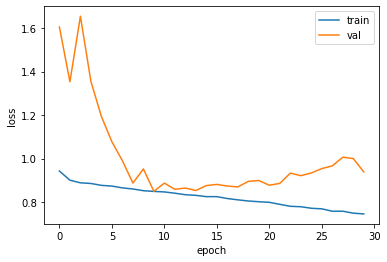

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

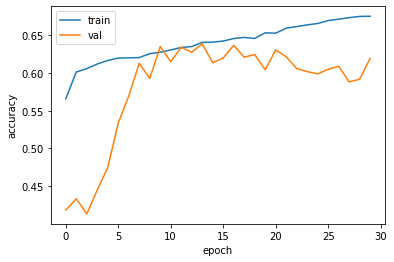

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [8]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
 
test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 2036 images belonging to 3 classes.


In [9]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_final.load_weights(latest)

model_final.evaluate(test_generator, steps=VALIDATION_SAMPLES // BATCH_SIZE)


31/31 [==============================] - 9s 303ms/step - loss: 0.8404 - acc: 0.6436


[0.8404375910758972, 0.6436492204666138]

In [10]:
model_final.save(f'./{NAME}_MobileNet.h5')
model_final.save(f'./{NAME}_MobileNet/MobileNet')

INFO:tensorflow:Assets written to: ./for_generator_korean(3_label)_MobileNet/MobileNet\assets


INFO:tensorflow:Assets written to: ./for_generator_korean(3_label)_MobileNet/MobileNet\assets
